# Target Trial Emulation in Python: Replicating an R Workflow

Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs. This notebook replicates an R-based workflow (from [this RPubs tutorial](https://rpubs.com/alanyang0924/TTE)) using Python.The goal is to mimic key aspects of the target trial framework by:

- **Data Loading and Preparation:** Loading a dummy dataset (saved as `data_censored.csv`) and generating additional variables (e.g. previous treatment, baseline treatment assignment, follow-up time).
- **Weight Calculation:** Estimating inverse probability of treatment switching weights and censoring weights via logistic regression, and combining these into overall stabilized weights.
- **Outcome Modeling:** Fitting a marginal structural model (MSM) with a weighted logistic regression to estimate the causal effect of treatment.
- **Prediction and Visualization:** Generating predicted survival probabilities (i.e. 1 minus predicted event risk) for different treatment scenarios over follow-up time and plotting the survival difference.

Below, we provide insights of each step along with the implementation.


In [9]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data and Overview

We load the dummy dataset (the file `data_censored.csv` should be in the same directory as this notebook). This dataset contains columns such as `id`, `period`, `treatment`, several covariates (`x1`, `x2`, etc.), `age`, `outcome`, `censored`, and `eligible`.

In [10]:
# Load the dummy data
data = pd.read_csv('..\data\data_censored.csv')
print('Data shape:', data.shape)
data.head()

Data shape: (725, 12)


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


## 2. Data Preparation

Before calculating the weights and fitting the outcome model, we prepare the data:

- **Previous Treatment:** For calculating treatment switching weights, we need the treatment status from the previous period. We group by `id` and shift the `treatment` column.
- **Assigned Treatment:** For an intention-to-treat (ITT) analysis, we define the assigned treatment as the treatment at baseline (i.e. the first period for each subject).
- **Trial Period & Follow-up Time:** We define the `trial_period` as the baseline period (minimum period per subject) and compute the follow-up time as the difference between the current period and the baseline.

In [11]:
# Create 'prev_treatment' by grouping by id and shifting the 'treatment' column
data = data.sort_values(by=['id', 'period']).reset_index(drop=True)
data['prev_treatment'] = data.groupby('id')['treatment'].shift(1)

# Create 'assigned_treatment' as the treatment at baseline for each id
baseline = data.groupby('id')['period'].transform('min')
data['trial_period'] = baseline  
data['assigned_treatment'] = data.groupby('id')['treatment'].transform('first')

# Define follow-up time as the difference between the current period and the baseline period
data['followup_time'] = data['period'] - data['trial_period']

print('Prepared data:')
data.head(10)

Prepared data:


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,prev_treatment,trial_period,assigned_treatment,followup_time
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,NaN,0,1,0
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,1.0,0,1,1
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1.0,0,1,2
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1.0,0,1,3
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,1.0,0,1,4
5,1,5,1,0,-0.057482,0,0.734203,41,0.500000,0,1,0,1.0,0,1,5
6,2,0,0,1,-0.802142,0,-0.990794,26,-0.750000,0,0,1,NaN,0,0,0
7,2,1,1,1,-0.983030,0,-0.990794,27,-0.666667,0,0,1,0.0,0,0,1
8,2,2,1,0,0.399388,0,-0.990794,28,-0.583333,0,0,0,1.0,0,0,2
9,2,3,0,0,1.835085,0,-0.990794,29,-0.500000,0,0,0,1.0,0,0,3


## 3. Define Functions to Compute Weights

We need to compute two types of weights:

1. **Treatment Switching Weights:**  
   - **Numerator Model:** Predicts the probability of receiving the treatment using only a subset of covariates (here, using `age`).
   - **Denominator Model:** Uses a richer set of covariates (here, `age + x1 + x3`).
   - We compute the stabilized weight as the ratio of the numerator probability to the denominator probability.
   - For the baseline period (when no previous treatment is available) we set the weight to 1.

2. **Censoring Weights:**  
   - The outcome of interest here is the probability of not being censored. We create a new variable (`not_censored`) which is `1 - censored`.
   - Numerator model: `not_censored ~ x2`
   - Denominator model: `not_censored ~ x2 + x1`

After calculating each, we multiply them to get the overall stabilized weight for each observation.

The following functions implement these steps using logistic regression.

In [12]:
def compute_stabilized_weight_switching(df):
    """
    Compute treatment switching stabilized weights.
    For observations with period > 0 (i.e. where a previous treatment exists),
    we compute the predicted probability using two models:
      - Numerator: treatment ~ age
      - Denom: treatment ~ age + x1 + x3
    The stabilized weight is: p_numerator / p_denominator
    For period == 0, we set the weight = 1.
    """
    weights = []
    # Loop over observations
    for idx, row in df.iterrows():
        if pd.isna(row['prev_treatment']) or row['period'] == 0:
            weights.append(1.0)
        else:
            # For simplicity, fit the models on the entire data with period > 0 and then get the predicted probability for this observation
            # In practice one would fit separate models for different previous treatment groups
            sub_df = df[df['period'] > 0]
            
            # Numerator model
            try:
                num_model = smf.glm(formula='treatment ~ age', data=sub_df, 
                                    family=sm.families.Binomial()).fit()
                p_num = num_model.predict(row)[0] if hasattr(num_model.predict(row), '__iter__') else num_model.predict(row)
            except Exception as e:
                p_num = 1.0
            
            # Denom model
            try:
                denom_model = smf.glm(formula='treatment ~ age + x1 + x3', data=sub_df, 
                                      family=sm.families.Binomial()).fit()
                p_denom = denom_model.predict(row)[0] if hasattr(denom_model.predict(row), '__iter__') else denom_model.predict(row)
            except Exception as e:
                p_denom = 1.0
            
            # Avoid division by zero
            if p_denom == 0:
                weight = 1.0
            else:
                weight = p_num / p_denom
            weights.append(weight)
    
    return np.array(weights)

def compute_stabilized_weight_censoring(df):
    """
    Compute censoring weights. We first define a new variable 'not_censored' = 1 - censored.
    Then we fit two logistic models:
       - Numerator: not_censored ~ x2
       - Denom: not_censored ~ x2 + x1
    The stabilized weight is the ratio of the predicted probability from the numerator model
    to that from the denominator model.
    """
    df = df.copy()
    df['not_censored'] = 1 - df['censored']
    
    # Fit numerator model
    num_model = smf.glm(formula='not_censored ~ x2', data=df, 
                        family=sm.families.Binomial()).fit()
    # Fit denominator model
    denom_model = smf.glm(formula='not_censored ~ x2 + x1', data=df, 
                          family=sm.families.Binomial()).fit()
    
    # Get predicted probabilities for not being censored
    p_num = num_model.predict(df)
    p_denom = denom_model.predict(df)
    
    # Compute stabilized weight (avoid division by zero)
    weight = np.where(p_denom == 0, 1.0, p_num / p_denom)
    
    return weight

# Apply the functions to compute weights
data['w_switch'] = compute_stabilized_weight_switching(data)
data['w_censor'] = compute_stabilized_weight_censoring(data)

# Overall weight as product of switching and censoring weights
data['wt'] = data['w_switch'] * data['w_censor']

print('Weights computed:')
data[['id', 'period', 'w_switch', 'w_censor', 'wt']].head(10)

Weights computed:


,id,period,w_switch,w_censor,wt
0,1,0,1.0,0.955481,0.955481
1,1,1,1.0,0.970647,0.970647
2,1,2,1.0,1.016972,1.016972
3,1,3,1.0,1.021899,1.021899
4,1,4,1.0,0.968208,0.968208
5,1,5,1.0,1.021173,1.021173
6,2,0,1.0,0.978403,0.978403
7,2,1,1.0,0.979868,0.979868
8,2,2,1.0,1.026743,1.026743
9,2,3,1.0,1.053732,1.053732


## 4. Fitting the Outcome Model

We now fit a marginal structural model (MSM) using weighted logistic regression. In our example, we model the outcome as a function of:

- **assigned_treatment:** the baseline treatment assignment
- **x2:** a covariate (also used in the censoring models)
- **followup_time** and its square: capturing the passage of time
- **trial_period** and its square: representing the baseline period (for illustration)

We use the overall weight (`wt`) computed above. The formula used is similar to the R code:

outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2)

In [13]:
# Create additional polynomial terms for the outcome model
data['followup_time_sq'] = data['followup_time'] ** 2
data['trial_period_sq'] = data['trial_period'] ** 2

# Fit the weighted logistic regression outcome model
outcome_formula = 'outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq + trial_period + trial_period_sq'

msm_model = smf.glm(formula=outcome_formula,
                    data=data,
                    family=sm.families.Binomial(),
                    freq_weights=data['wt']).fit()

print(msm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  725
Model:                            GLM   Df Residuals:                   720.60
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.426
Date:                Sun, 09 Mar 2025   Deviance:                       108.85
Time:                        18:28:41   Pearson chi2:                     670.
No. Iterations:                     8   Pseudo R-squ. (CS):           0.006617
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.2875      0

## 5. Prediction and Plotting Survival Probability

We now generate predictions from the outcome model. In the R tutorial, predictions are made for survival probabilities over follow-up time for different treatment groups. Here we:

- Define a new dataframe with follow-up times from 0 to 10.
- Assume a fixed (average) value for covariate `x2` and a fixed `trial_period` (here set to 0 for simplicity).
- Generate predictions for each treatment group (assigned_treatment = 0 and 1).
- Convert the predicted probability of the outcome to a survival probability (i.e. `survival = 1 - predicted risk`).
- Compute the difference in survival between treatment groups and plot it over time.

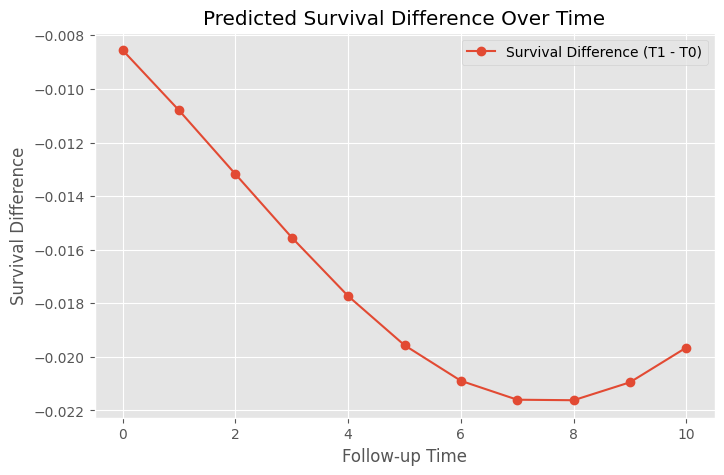

In [14]:
# Define a range of follow-up times
followup_range = np.arange(0, 11)

# Assume average x2 value from the data
avg_x2 = data['x2'].mean()

# Create prediction data for each treatment group
def create_pred_df(assigned_treatment, trial_period=0):
    df_pred = pd.DataFrame({
        'assigned_treatment': assigned_treatment,
        'x2': avg_x2,
        'followup_time': followup_range,
        'trial_period': trial_period
    })
    df_pred['followup_time_sq'] = df_pred['followup_time'] ** 2
    df_pred['trial_period_sq'] = df_pred['trial_period'] ** 2
    return df_pred

# Create prediction datasets for treatment = 1 and treatment = 0
pred_df_t1 = create_pred_df(assigned_treatment=1)
pred_df_t0 = create_pred_df(assigned_treatment=0)

# Get predicted probabilities (risk) for each group
pred_risk_t1 = msm_model.predict(pred_df_t1)
pred_risk_t0 = msm_model.predict(pred_df_t0)

# Convert to survival probability
surv_t1 = 1 - pred_risk_t1
surv_t0 = 1 - pred_risk_t0

# Survival difference: treatment 1 minus treatment 0
surv_diff = surv_t1 - surv_t0

# Plot the survival difference over follow-up time
plt.figure(figsize=(8, 5))
plt.plot(followup_range, surv_diff, marker='o', label='Survival Difference (T1 - T0)')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Difference')
plt.title('Predicted Survival Difference Over Time')
plt.legend()
plt.show()


In this notebook we have:

- **Prepared the data** by computing key variables needed for a target trial emulation including baseline treatment, previous treatment, and follow-up time.
- **Computed inverse probability weights** to adjust for treatment switching and informative censoring. These stabilized weights help reduce biases inherent in observational studies.
- **Fitted a marginal structural model (MSM)** using weighted logistic regression to estimate the effect of treatment on the outcome.
- **Generated and visualized predictions** that illustrate how the survival probability differs over time between the treatment groups.

This workflow demonstrates how modern epidemiologic methods can be implemented in Python to mimic a target trial and draw causal inferences from observational data.